<a href="https://colab.research.google.com/github/Gorodecki/Projects/blob/master/NLP_Tag_Conv1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Нахождение тэгов русских слов с помощью сверточных сетей

In [ ]:
pip install pymorphy2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Embedding, Conv1D, SpatialDropout1D, BatchNormalization, GlobalMaxPooling1D, Dense, Dropout, MaxPooling1D, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, Sequential

import pymorphy2
import re
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/Neural Base/Данные/(Стругацкие) Тестовая_2 вместе.txt', 'r') as f:
  text = f.read()
  text = text.replace('\ufeff', '')  
  text = re.sub(r'[^А-я\n]', ' ', text)
  text = ' '.join(text.split())

In [ ]:
text

'ОТЕЛЬ У ПОГИБШЕГО АЛЬПИНИСТА ГЛАВА Я остановил машину вылез и снял черные очки Все было так как рассказывал Згут Отель был двухэтажный желтый с зеленым над крыльцом красовалась траурная вывеска У ПОГИБШЕГО АЛЬПИНИСТА Высокие ноздреватые сугробы по сторонам крыльца были утыканы разноцветными лыжами я насчитал семь штук одна была с ботинком С крыши свисали мутные гофрированные сосульки толщиной в руку В крайнее правое окно первого этажа выглянуло чье то бледное лицо и тут парадная дверь отворилась и на крыльце появился лысый коренастый человек в рыжем меховом жилете поверх ослепительной лавсановой рубашки Тяжелой медлительной поступью он приблизился и остановился передо мною У него была грубая красная физиономия и шея борца тяжеловеса На меня он не смотрел Его меланхолический взгляд был устремлен куда то в сторону и исполнен печального достоинства Несомненно это был сам Алек Сневар владелец отеля долины и Бутылочного Горлышка Там произнес он неестественно низким и глухим голосом Вон там

In [ ]:
words = list(set(text.lower().split(' ')))
len(words)

24099

In [ ]:
words[:20]

In [ ]:
num_chars = 32 #33 буквы - ё
tokenizer = Tokenizer(num_words=num_chars, char_level=True) #русский алфавит без ё
tokenizer.fit_on_texts(words)

In [ ]:
tokenizer.word_index

In [ ]:
tokenizer.texts_to_sequences(['привет', 'пока'])

[[11, 8, 4, 10, 3, 6], [11, 1, 12, 2]]

In [ ]:
maxlen = max([len(i) for i in words])
maxlen

24

In [ ]:
pad_sequences([tokenizer.texts_to_sequences('привет')], maxlen=maxlen, padding='post') #принимает батч

In [ ]:
Xtrain = pad_sequences(tokenizer.texts_to_sequences(words), maxlen=maxlen, padding='post')

In [ ]:
Xtrain

array([[11,  1, 15, ...,  0,  0,  0],
       [10,  1,  7, ...,  0,  0,  0],
       [ 8,  4,  7, ...,  0,  0,  0],
       ...,
       [10, 17,  6, ...,  0,  0,  0],
       [15,  3,  8, ...,  0,  0,  0],
       [20,  3,  9, ...,  0,  0,  0]], dtype=int32)

In [ ]:
Xtrain.shape

(24099, 24)

# Разбираем на тэги


> Полный набор допустимых граммем и то, что они означают, можно посмотреть по этой ссылке: http://opencorpora.org/dict.php?act=gram



In [ ]:
tag_dict = ['POS', 'animacy', 'gender', 'number', 'tense']

In [ ]:
morph = pymorphy2.MorphAnalyzer()

In [ ]:
# не хватает умений как это было реализовать в цикле
# как превратить строку в имя переменной и параметр ?
pos_tags = [str(morph.parse(word)[0].tag.POS) for word in words]
animacy_tags = [str(morph.parse(word)[0].tag.animacy) for word in words]
gender_tags = [str(morph.parse(word)[0].tag.gender) for word in words]
number_tags = [str(morph.parse(word)[0].tag.number) for word in words]
tense_tags = [str(morph.parse(word)[0].tag.tense) for word in words]

In [ ]:
# словарь граммем
grammem_dict = {0:pos_tags,
                1:animacy_tags,
                2:gender_tags,
                3:number_tags,
                4:tense_tags}

In [ ]:
pos_tags_tok = Tokenizer()
pos_tags_tok.fit_on_texts(pos_tags)
animacy_tags_tok = Tokenizer()
animacy_tags_tok.fit_on_texts(animacy_tags)
gender_tags_tok = Tokenizer()
gender_tags_tok.fit_on_texts(gender_tags)
number_tags_tok = Tokenizer()
number_tags_tok.fit_on_texts(number_tags)
tense_tags_tok = Tokenizer()
tense_tags_tok.fit_on_texts(tense_tags)

In [ ]:
print(pos_tags_tok.index_word)
print(animacy_tags_tok.index_word)
print(gender_tags_tok.index_word)
print(number_tags_tok.index_word)
print(tense_tags_tok.index_word)

{1: 'noun', 2: 'verb', 3: 'adjf', 4: 'infn', 5: 'advb', 6: 'prtf', 7: 'grnd', 8: 'adjs', 9: 'prts', 10: 'none', 11: 'numr', 12: 'comp', 13: 'conj', 14: 'npro', 15: 'prep', 16: 'prcl', 17: 'intj', 18: 'pred'}
{1: 'none', 2: 'inan', 3: 'anim'}
{1: 'masc', 2: 'none', 3: 'femn', 4: 'neut'}
{1: 'sing', 2: 'plur', 3: 'none'}
{1: 'none', 2: 'past', 3: 'pres', 4: 'futr'}


In [ ]:
Ytrain_pos_tags = pos_tags_tok.texts_to_matrix(pos_tags)[:, 1:]
Ytrain_animacy_tags = animacy_tags_tok.texts_to_matrix(animacy_tags)[:, 1:]
Ytrain_gender_tags = gender_tags_tok.texts_to_matrix(gender_tags)[:, 1:]
Ytrain_number_tags = number_tags_tok.texts_to_matrix(number_tags)[:, 1:]
Ytrain_tense_tags = tense_tags_tok.texts_to_matrix(tense_tags)[:, 1:]

In [ ]:
print(Ytrain_pos_tags.shape)
print(Ytrain_animacy_tags.shape)
print(Ytrain_gender_tags.shape)
print(Ytrain_number_tags.shape)
print(Ytrain_tense_tags.shape)

(24099, 18)
(24099, 3)
(24099, 4)
(24099, 3)
(24099, 4)


In [ ]:
emb_size = 50

inputs = Input(shape=(maxlen,))
x = Embedding(num_chars+1, emb_size, input_length=maxlen)(inputs)
x = SpatialDropout1D(0.2)(x)
x = Conv1D(256, 3, activation='relu', padding='same', strides=1)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
output_0 = Dense(Ytrain_pos_tags.shape[1], activation='softmax', name='out_0')(x)
output_1 = Dense(Ytrain_animacy_tags.shape[1], activation='softmax', name='out_1')(x)
output_2 = Dense(Ytrain_gender_tags.shape[1], activation='softmax', name='out_2')(x)
output_3 = Dense(Ytrain_number_tags.shape[1], activation='softmax', name='out_3')(x)
output_4 = Dense(Ytrain_tense_tags.shape[1], activation='softmax', name='out_4')(x)

model_four = Model(inputs=inputs, outputs=[output_0, output_1, output_2, output_3, output_4])

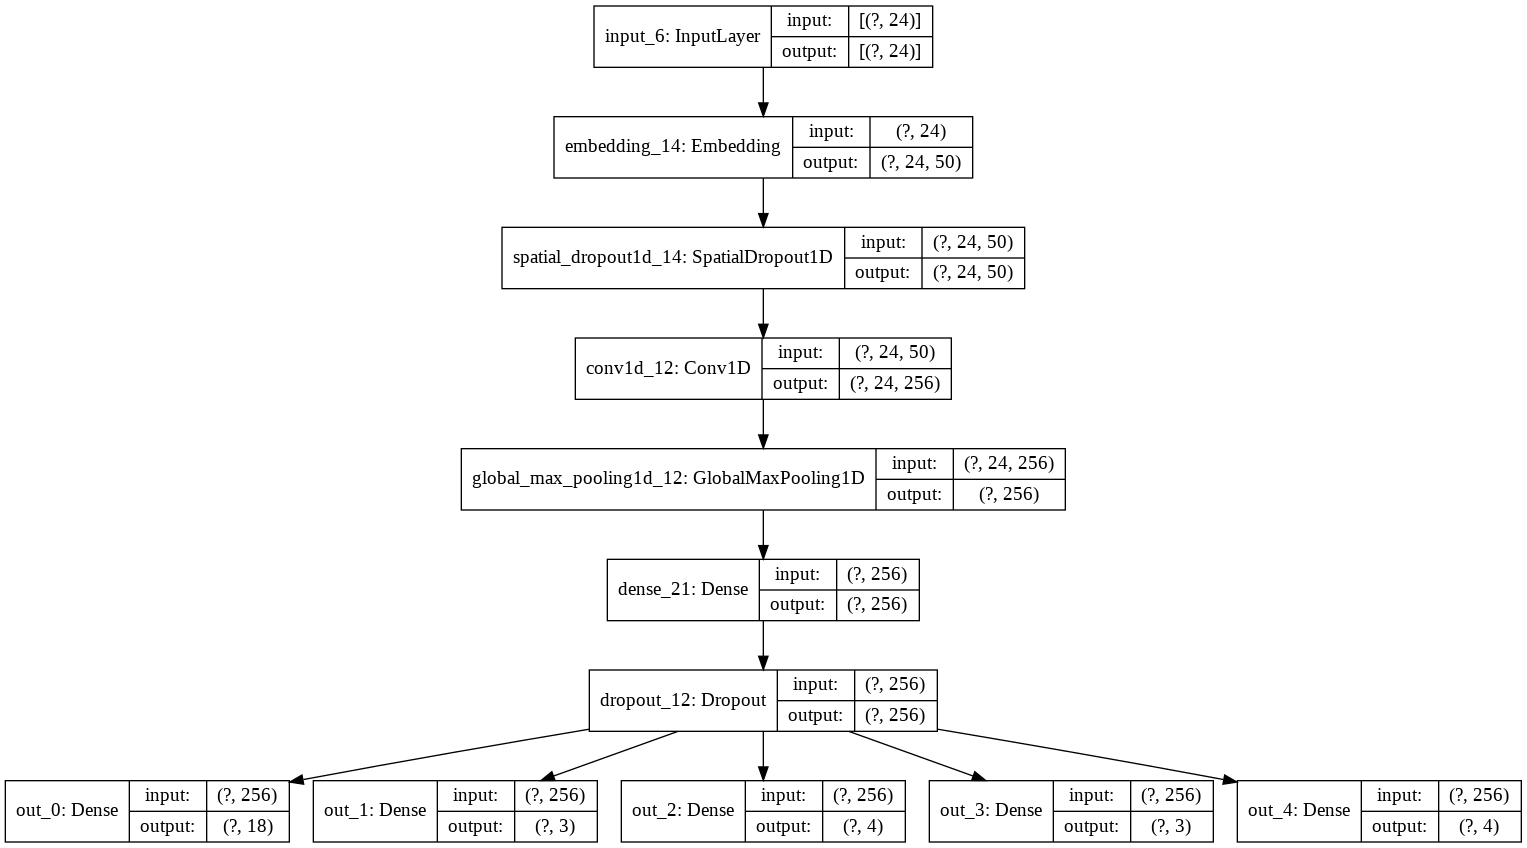

In [ ]:
plot_model(model_four, show_shapes=True)

In [ ]:
model_four.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
model_four.fit(Xtrain, [Ytrain_pos_tags, Ytrain_animacy_tags, Ytrain_gender_tags, Ytrain_number_tags, Ytrain_tense_tags], epochs=15, batch_size = 64, validation_split=0.2)

Epoch 1/15
302/302 [==============================] - 5s 17ms/step - loss: 1.6200 - out_0_loss: 0.3930 - out_1_loss: 0.3710 - out_2_loss: 0.4411 - out_3_loss: 0.2515 - out_4_loss: 0.1635 - out_0_accuracy: 0.8775 - out_1_accuracy: 0.8528 - out_2_accuracy: 0.8324 - out_3_accuracy: 0.9045 - out_4_accuracy: 0.9388 - val_loss: 1.7299 - val_out_0_loss: 0.4348 - val_out_1_loss: 0.3976 - val_out_2_loss: 0.4549 - val_out_3_loss: 0.2670 - val_out_4_loss: 0.1756 - val_out_0_accuracy: 0.8718 - val_out_1_accuracy: 0.8382 - val_out_2_accuracy: 0.8230 - val_out_3_accuracy: 0.9002 - val_out_4_accuracy: 0.9371
Epoch 2/15
302/302 [==============================] - 5s 17ms/step - loss: 1.6068 - out_0_loss: 0.3912 - out_1_loss: 0.3671 - out_2_loss: 0.4333 - out_3_loss: 0.2480 - out_4_loss: 0.1672 - out_0_accuracy: 0.8780 - out_1_accuracy: 0.8574 - out_2_accuracy: 0.8332 - out_3_accuracy: 0.9056 - out_4_accuracy: 0.9383 - val_loss: 1.6953 - val_out_0_loss: 0.4257 - val_out_1_loss: 0.3894 - val_out_2_loss: 

In [ ]:
#Калушата присяпали и Бутявку стрямкали. И подудонились.
word = 'кошками'
x = pad_sequences(tokenizer.texts_to_sequences([word]), maxlen=maxlen, padding='post')
#pos = all_gramem_tokenizer.index_word[np.argmax(model(x))+1]
res = model_four.predict(x)
res = [np.argmax(x[0])+1 for x in res]
print(res)
answer = pos_tags_tok.index_word[res[0]] + ' ' + animacy_tags_tok.index_word[res[1]] +' ' + gender_tags_tok.index_word[res[2]] +' ' + number_tags_tok.index_word[res[3]] +' ' + tense_tags_tok.index_word[res[4]]
print(answer)
print(morph.lat2cyr(answer))
print(morph.parse(word)[0].tag)

[1, 2, 3, 2, 1]
noun inan femn plur none
noun неод жр мн none
NOUN,inan,femn plur,ablt


Граммема | Значение | пример
--- | --- | ---
NOUN |	имя существительное |	хомяк
ADJF|	имя прилагательное (полное)|	хороший
ADJS|	имя прилагательное (краткое)|	хорош
COMP|	компаратив	|лучше, получше, выше
VERB|	глагол (личная форма)|	говорю, говорит, говорил
INFN|	глагол (инфинитив)|	говорить, сказать
PRTF	|причастие (полное)|	прочитавший, прочитанная
PRTS	|причастие (краткое)|	прочитана
GRND|	деепричастие|	прочитав, рассказывая
NUMR	|числительное|	три, пятьдесят
ADVB|	наречие|	круто
NPRO	|местоимение-существительное|	он
PRED|	предикатив|	некогда
PREP	|предлог|	в
CONJ|	союз|	и
PRCL	|частица|	бы, же, лишь
INTJ|	междометие|	ой

# Шпаргалка по размерностям

In [ ]:
layer = Conv1D(1, 2)

In [ ]:
T = np.random.randn(2, 2, 5)

In [ ]:
layer(T)

<tf.Tensor: shape=(2, 1, 1), dtype=float32, numpy=
array([[[-1.0441107]],

       [[-0.4107789]]], dtype=float32)>

In [ ]:
layer.get_weights()[0].shape

(2, 5, 1)

In [ ]:
layer.get_weights()[0]

array([[[-0.07502592],
        [ 0.38706118],
        [ 0.5320987 ],
        [ 0.2975033 ],
        [-0.27270782]],

       [[-0.5811789 ],
        [-0.6770176 ],
        [-0.50468844],
        [ 0.34137434],
        [-0.6405704 ]]], dtype=float32)

In [ ]:
T[0]

array([[ 0.03747146, -1.86751387,  0.86069303, -1.39195317,  0.05034665],
       [ 0.73940857, -0.59758244,  1.41260669,  1.30453169,  0.08717681]])

In [ ]:
np.sum(layer.get_weights()[0][:,:,0] * T[0])

-1.0441107020540106

In [ ]:
np.sum(layer.get_weights()[0][:,:,0] * T[1])

-0.4107789458500636